In [83]:
import os
import sys
import re
import matplotlib.pyplot as plt
import numpy as np

In [84]:
# Archivo de logs
log_file = "individual_files_training_segment-10023947602400723454_1120_000_1140_000_with_camera_labels_Association_Test3_Logs.txt"
with open(log_file, "r") as file:
    log_data = file.read()

In [85]:
# Expresión regular para capturar las distancias de Mahalanobis
mahalanobis_pattern = re.compile(r"Min distance for observation \d+: ([\d\.]+)")
# Expresión regular para capturar las matrices de incertidumbre
uncertainty_state_pattern = re.compile(r"Incertidumbre del estado:\n((?:[\d\.e\-]+\s+)+)\n")
uncertainty_obs_pattern = re.compile(r"Incertidumbre de las observaciones:\n((?:[\d\.e\-]+\s+)+)\n")
# Expresión regular para capturar el número total de observaciones
total_observations_pattern = re.compile(r"EKF Number of observations received: (\d+)")
# Expresión regular para capturar el número de asociaciones correctas
correct_associations_pattern = re.compile(r"EKF MATCH FOUND")

In [86]:
# Listas para almacenar datos
frame_numbers = []
mahalanobis_distances = []
uncertainty_state_values = []
uncertainty_obs_values = []
total_observations = 0
correct_associations = 0

frame_count = 0
current_distances = []

# Extraer incertidumbre, distancias de Mahalanobis y asociaciones correctas
lines = log_data.split("\n")
for i, line in enumerate(lines):
    if "CLIENT New Frame" in line:
        if current_distances:  # Guardar el mínimo si hay valores almacenados
            min_distance = min(current_distances)
            if min_distance <= 5:  # Filtrar outliers
                frame_numbers.append(frame_count)
                mahalanobis_distances.append(min_distance)
            current_distances = []  # Reiniciar para el siguiente frame
        frame_count += 1  # Nuevo frame
    
    match = mahalanobis_pattern.search(line)
    if match:
        distance = float(match.group(1))
        current_distances.append(distance)
    
    if "Incertidumbre del estado:" in line:
        matrix_lines = lines[i+1:i+7]  # Extraer las 6 líneas siguientes que contienen la matriz
        matrix = np.array([[float(num) for num in row.split()] for row in matrix_lines])
        uncertainty_state_values.append(np.trace(matrix))  # Calcular la traza de la matriz
    
    if "Incertidumbre de las observaciones:" in line:
        matrix_lines = lines[i+1:i+7]  # Extraer las 6 líneas siguientes que contienen la matriz
        matrix = np.array([[float(num) for num in row.split()] for row in matrix_lines])
        uncertainty_obs_values.append(np.trace(matrix))  # Calcular la traza de la matriz
    
    if correct_associations_pattern.search(line):
        correct_associations += 1

    match_total = total_observations_pattern.search(line)
    if match_total:
        total_observations += int(match_total.group(1))

In [87]:
# Mostrar el número total de observaciones
print(f"Número total de observaciones: {total_observations}")
# Mostrar el número total de asociaciones correctas
print(f"Número total de asociaciones correctas: {correct_associations}")

Número total de observaciones: 60
Número total de asociaciones correctas: 13


In [88]:
# Calcular tasa de éxito de asociación
success_rate = (correct_associations / total_observations) * 100 if total_observations > 0 else 0

In [89]:
# Guardar el último frame si hay datos pendientes
if current_distances:
    min_distance = min(current_distances)
    frame_numbers.append(frame_count)
    mahalanobis_distances.append(min_distance)

In [90]:
# Ajustar regresión lineal
coeffs = np.polyfit(frame_numbers, mahalanobis_distances, 1)
trend_line = np.poly1d(coeffs)

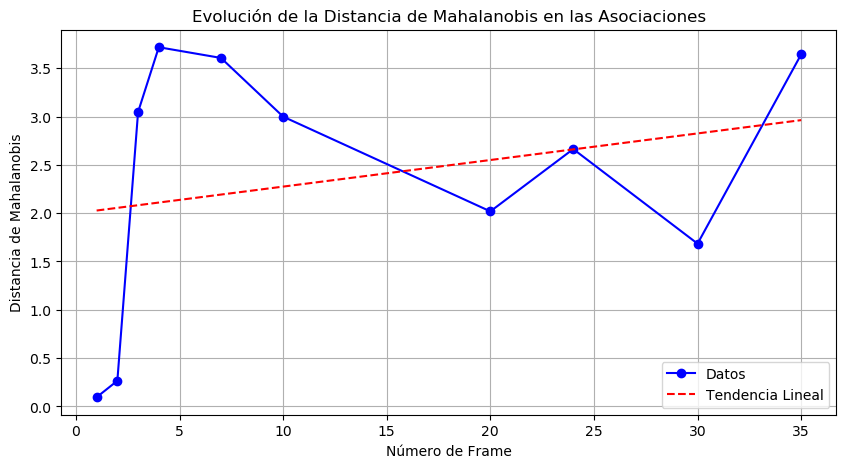

In [91]:
# Graficar los resultados
plt.figure(figsize=(10, 5))
plt.plot(frame_numbers, mahalanobis_distances, marker='o', linestyle='-', color='b', label="Datos")
plt.plot(frame_numbers, trend_line(frame_numbers), linestyle='--', color='r', label="Tendencia Lineal")
plt.xlabel("Número de Frame")
plt.ylabel("Distancia de Mahalanobis")
plt.title("Evolución de la Distancia de Mahalanobis en las Asociaciones")
plt.legend()
plt.grid()

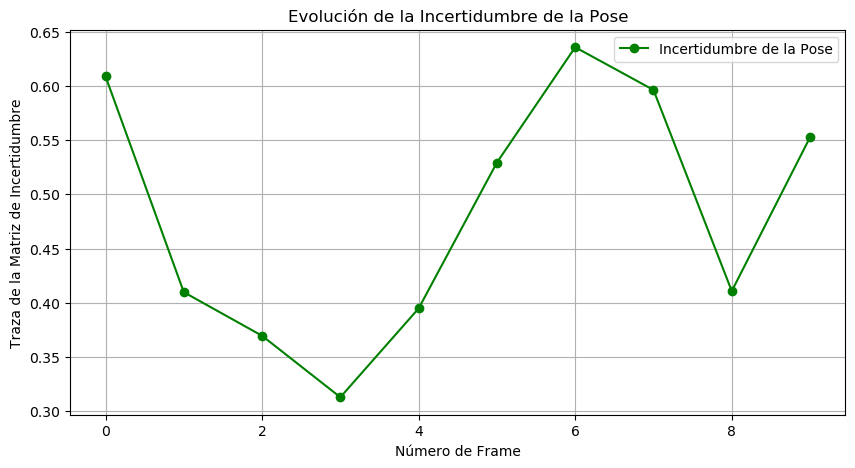

In [92]:
# Graficar la evolución de la incertidumbre de la pose
plt.figure(figsize=(10, 5))
plt.plot(range(len(uncertainty_state_values)), uncertainty_state_values, marker='o', linestyle='-', color='g', label="Incertidumbre de la Pose")
plt.xlabel("Número de Frame")
plt.ylabel("Traza de la Matriz de Incertidumbre")
plt.title("Evolución de la Incertidumbre de la Pose")
plt.legend()
plt.grid()
plt.show()

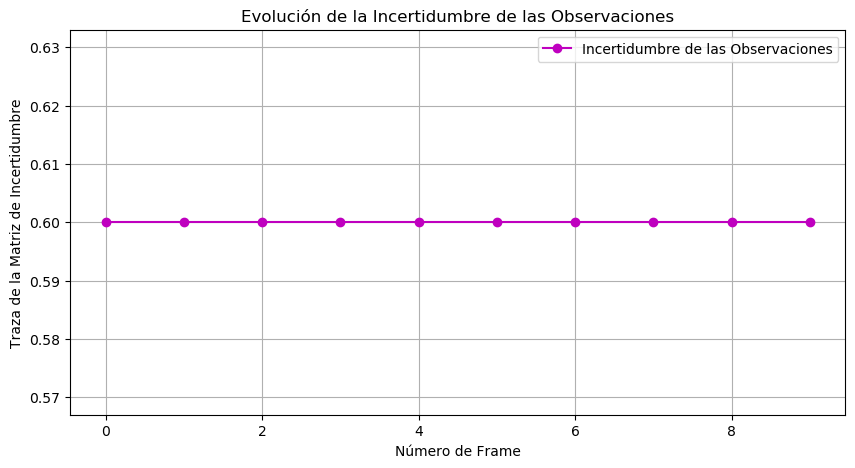

In [93]:
# Graficar la evolución de la incertidumbre de las observaciones
plt.figure(figsize=(10, 5))
plt.plot(range(len(uncertainty_obs_values)), uncertainty_obs_values, marker='o', linestyle='-', color='m', label="Incertidumbre de las Observaciones")
plt.xlabel("Número de Frame")
plt.ylabel("Traza de la Matriz de Incertidumbre")
plt.title("Evolución de la Incertidumbre de las Observaciones")
plt.legend()
plt.grid()
plt.show()


In [94]:
#Mostrar métricas
print(f"Número total de asociaciones correctas: {correct_associations}")
print(f"Número total de observaciones realizadas: {total_observations}")
print(f"Tasa de éxito de asociación: {success_rate:.2f}%")
print(f"Promedio de distancia de Mahalanobis: {np.mean(mahalanobis_distances):.2f} ± {np.std(mahalanobis_distances):.2f}")
print(f"Promedio de incertidumbre de la pose: {np.mean(uncertainty_state_values):.2f} ± {np.std(uncertainty_state_values):.2f}")
print(f"Promedio de incertidumbre de las observaciones: {np.mean(uncertainty_obs_values):.2f} ± {np.std(uncertainty_obs_values):.2f}")

Número total de asociaciones correctas: 13
Número total de observaciones realizadas: 60
Tasa de éxito de asociación: 21.67%
Promedio de distancia de Mahalanobis: 2.37 ± 1.27
Promedio de incertidumbre de la pose: 0.48 ± 0.11
Promedio de incertidumbre de las observaciones: 0.60 ± 0.00
